In [1]:
# Libraries:
import pysindy as ps
import numpy as np
import matplotlib.pyplot as plt
import dill
import sys
import os

from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import Lasso

sys.path.append("/home/mattg/D_CODE") # A questo punto è necessario per non doverlo chiamare i file che usano D_CODE.
from D_CODE.run_simulation import run as run_SRT
from D_CODE.run_simulation_vi import run as run_DCODE
from toolbox.auxiliary_functions import set_param_freq

from data import equations
from data import SINDy_data

/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


In [2]:
# Select ODE & settings:
ode_name = 'TVSelkovODE' # help="name of the ode", type=str
ode_param = '0.95,0.60,0.1' # help="parameters of the ode (default: None)", type=str, default=None
freq = 10 # Dovrebbe essere 195 per avere dt = 5.130 * 10−3 come nel paper di riferimento
dt = 1 / freq
n_sample = 50 # help="number of trajectories", type=int, default=100
noise_ratio = 0.01 # help="noise level (default 0)", type=float, default=0.
dim_x = 3 # help="dimentionality of the problem", type=int
dim_k = 0 # help="dimentionality of the parameterizaiton discovery", type=int
ode_param, freq = set_param_freq(ode_param, freq)
ode = equations.get_ode(ode_name, ode_param)
time_vector = np.arange(0, ode.T + dt, dt)

In [3]:
# generate data:
X_list, dX_list, param_list, feature_names = SINDy_data.SINDy_data(ode_name=ode_name, 
                                                                   ode_param=ode_param,
                                                                   freq=freq,
                                                                   n_sample=n_sample,
                                                                   noise_ratio=noise_ratio,
                                                                   dim_x=dim_x,
                                                                   dim_k=dim_k)
# X_list = SINDy_data.existence_conditions(X_list, ode.init_low, n_variables=dim_x)

# save data:
# file_path = 'saved/data/TVSelkovODE_data.pkl'
# os.makedirs(os.path.dirname(file_path), exist_ok=True)
# with open(file_path, 'wb') as f:
#     dill.dump((X_list, dX_list, param_list, feature_names), f)

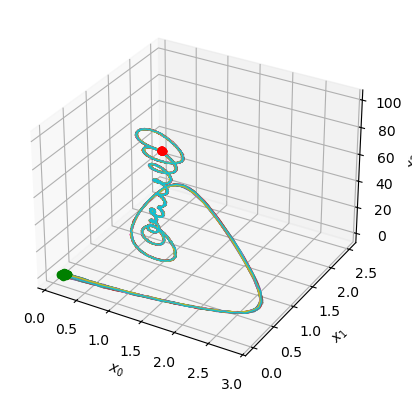

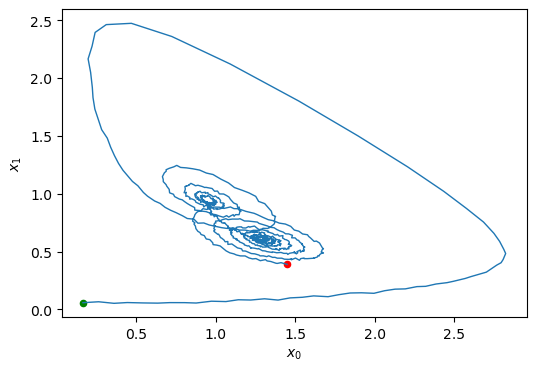

In [4]:
SINDy_data.plot_configuration(X_list)
SINDy_data.plot_configuration(np.array(X_list)[:1,:,0:2])

In [3]:
from toolbox.symbolic_SINDy import *
from toolbox.SINDy import *

In [4]:
param = ode_param
noise_sigma = 0.01
seed = 100
n_seed = 1
T0 = 35
T = 42

SimDY=symbolic_SINDy()
SimDY.SRT_simulation(ode_name, param, freq, n_sample, noise_sigma, seed, n_seed, T0, T)


Searching for additonal building blocks -> SR-T call:

Running with: ode_name=TVSelkovODE, ode_param=[0.95, 0.6, 0.1], x_id=0, freq=10, n_sample=50, noise_sigma=0.01, alg=tv, seed=100, n_seed=1
Dataset shape:  (71, 50, 3)
Functions set:  {'neg': 1, 'mul': 1, 'log': 1, 'add': 1, 'sub': 1, 'pow': 1, 'sin': 1, 'sig': 1}
 
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     7.80            96708        5        0.0122736        0.0124729      1.63m


/home/mattg/gplearn/gplearn/functions.py:132: RuntimeWarning: overflow encountered in power
  return np.where(np.logical_and(np.minimum(x1, x2) >= 0, np.maximum(x1, x2) <= 10), np.power(x1, x2), 1000)


   1     5.38          368.852       11        0.0114001        0.0110724      1.59m
   2     2.49          62.8691        5        0.0132757        0.0132955      1.35m
   3     2.16          48.5132       13         0.013693        0.0128816      1.15m
   4     1.58          104.685        4        0.0217485        0.0227454     57.47s
   5     1.37          273.417        8        0.0213729        0.0218309     51.11s


InvalidPrefixExpression: Incorrect prefix expression "['mul', 'sub', '0', 'ln', 'X0', 'ln', 'sig', 'sin', 'X1']". "['sin', 'X1']" was not parsed.

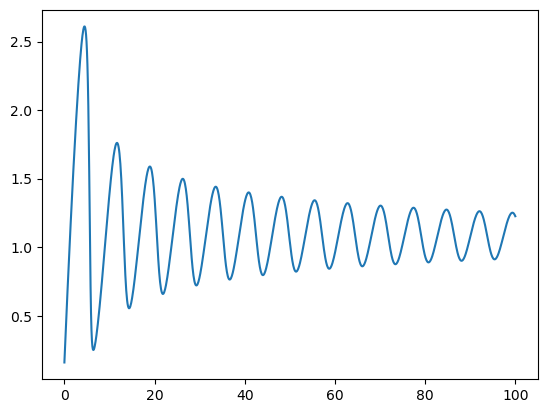

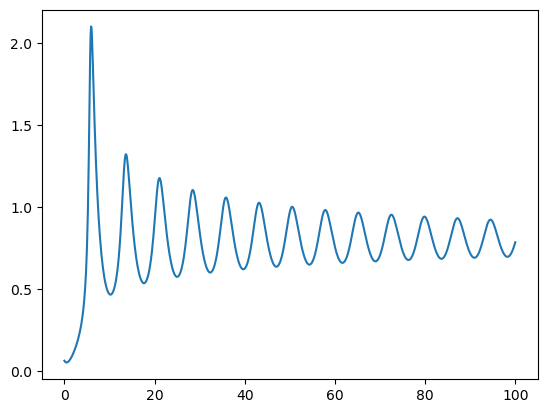

In [6]:
for i in range(1):
    X = np.array(X_list[i])
    vec = np.linspace(0, 100, 1000)
    plt.plot(vec, X[:,0])

plt.show()

for i in range(1):
    X = np.array(X_list[i])
    vec = np.linspace(0, 100, 1000)
    plt.plot(vec, X[:,1])

# for i in range(20):
#     X = np.array(X_list[i])
#     vec = np.linspace(60, 90, 300)
#     plt.plot(vec, X[600:900,0])

# for i in range(20):
#     X = np.array(X_list[i])
#     vec = np.linspace(90, 110, 200)
#     plt.plot(vec, X[900:1100,0])

In [6]:
X_lista = [np.array(x)[:150, :] for x in X_list]
dX_lista = [np.array(dx)[:150, :] for dx in dX_list]

model = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=True), optimizer=ps.STLSQ(threshold=0.08))
model.fit(X_lista, t=dt, multiple_trajectories=True, x_dot=dX_lista)
print("Estimated SINDy model: ")
model.print()

Estimated SINDy model: 
(X0)' = 0.433 1 + 0.135 X1 + -1.087 X0 X1^2
(X1)' = 0.100 X0 + -0.986 X1 + 0.984 X0 X1^2
(X2)' = 1.000 1


In [ ]:
X_lista = [np.array(x)[:150, :] for x in X_list]
dX_lista = [np.array(dx)[:150, :] for dx in dX_list]

model = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=True), optimizer=ps.STLSQ(threshold=0.08))
model.fit(X_lista, t=dt, multiple_trajectories=True, x_dot=dX_lista)
print("Estimated SINDy model: ")
model.print()

Estimated SINDy model: 
(X0)' = 0.693 1 + 0.249 X1 + -0.275 X0 X1 + -0.122 X1^2 + -0.846 X0 X1^2
(X1)' = 0.100 X0 + -0.994 X1 + 0.994 X0 X1^2
(X2)' = 1.000 1
